In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error

import warnings  # supress warnings

warnings.filterwarnings("ignore")

# Load Data

In [2]:
housing = pd.read_csv("../../../Data/Housing.csv")
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
len(housing.index)

545

In [4]:
len(housing)

545

# Regression based on 1 feature only

## area ~ price

In [5]:
df = housing.loc[:, ["area", "price"]]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


In [6]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


<Axes: xlabel='area', ylabel='price'>

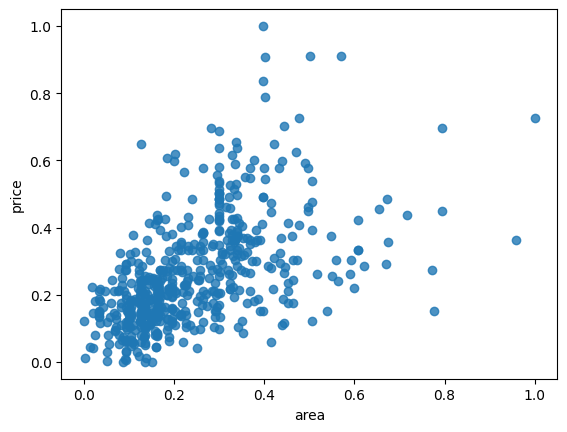

In [7]:
# visualise area-price relationship
sns.regplot(x="area", y="price", data=df, fit_reg=False)

In [8]:
# split into train and test
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=10)
print(len(df_train))
print(len(df_test))

381
164


In [9]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train["area"]
X_train = X_train.values.reshape(-1, 1)
y_train = df_train["price"]

X_test = df_test["area"]
X_test = X_test.values.reshape(-1, 1)
y_test = df_test["price"]

In [10]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

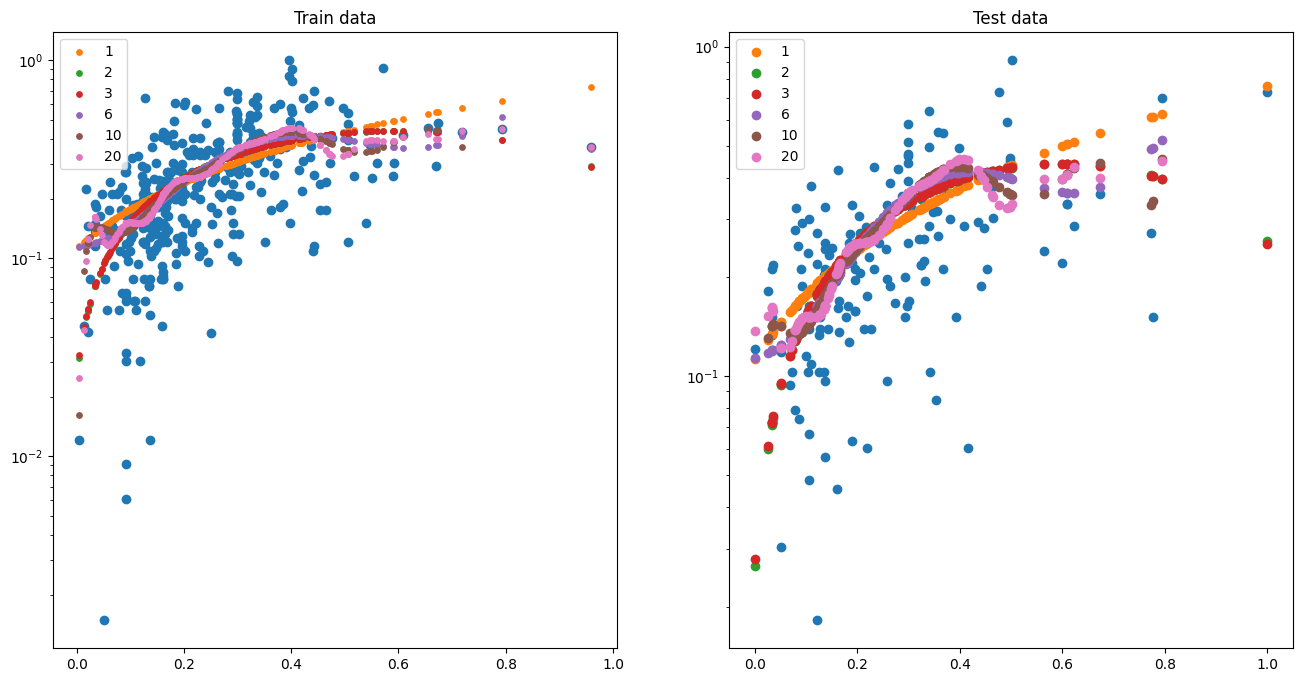

In [11]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale("log")
plt.title("Train data")
for i, degree in enumerate(degrees):
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc="upper left")

# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale("log")
plt.title("Test data")
for i, degree in enumerate(degrees):
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc="upper left")

In [12]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print(
        "Polynomial degree {0}: train score={1}, test score={2}".format(
            degree, train_r2, test_r2
        )
    )

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-301255508186.63


# 1. Building a MLR Model Without Cross-Validation

## Data Prep

In [13]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea",
]


# defining the map function
def binary_map(x):
    return x.map({"yes": 1, "no": 0})


# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [14]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus'
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing["furnishingstatus"], drop_first=True)
status.head()

,semi-furnished,unfurnished
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


In [15]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,False,False


In [16]:
# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(["furnishingstatus"], axis=1, inplace=True)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [17]:
# train-test 70-30 split
df_train, df_test = train_test_split(
    housing, train_size=0.7, test_size=0.3, random_state=100
)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns
numeric_vars = ["area", "bedrooms", "bathrooms", "stories", "parking", "price"]
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,False,True
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,True,False
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,False,False
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,False,False
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,False,True


In [18]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,True,False
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,True,False
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,True,False
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,True,False
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,True,False


In [19]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop("price")
X_train = df_train

y_test = df_test.pop("price")
X_test = df_test

## Using recursive feature elimination (RFE)

In [20]:
# num of max features
len(X_train.columns)

13

In [21]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [22]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [23]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5812051458999572


In [24]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5350445027578823


# 2. Building a MLR Model With Cross-Validation (K-Fold)

## K-Fold

In [25]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring="r2", cv=5)
scores

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [26]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)
scores = cross_val_score(lm, X_train, y_train, scoring="r2", cv=folds)
scores

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [29]:
# can tune other metrics, such as MSE
scoring_metrics = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(lm, X_train, y_train, scoring=scoring_metrics, cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

## Hyperparameter Tuning Using Grid Search Cross-Validation

In [30]:
# number of features in X_train
len(X_train.columns)

13

In [31]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits=5, shuffle=True, random_state=100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{"n_features_to_select": list(range(1, len(X_train.columns) + 1))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(
    estimator=rfe,
    param_grid=hyper_params,
    scoring="r2",
    cv=folds,
    verbose=1,
    return_train_score=True,
)

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [32]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008591,0.007130,0.000450,0.000900,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.006868,0.005212,0.000590,0.000377,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.008522,0.008327,0.000413,0.000506,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.003989,0.002084,0.000598,0.000488,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.006278,0.007689,0.003126,0.006253,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.006289,0.001873,0.000806,0.000403,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.003563,0.001305,0.000797,0.000399,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.006275,0.007685,0.000000,0.000000,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.000000,0.000000,0.003126,0.006251,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.000000,0.000000,0.003127,0.006255,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


In [33]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_features_to_select', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [35]:
cv_results[
    [
        "mean_fit_time",
        "mean_score_time",
        "params",
        "mean_train_score",
        "mean_test_score",
        "rank_test_score",
    ]
]

,mean_fit_time,mean_score_time,params,mean_train_score,mean_test_score,rank_test_score
0,0.008591,0.000450,{'n_features_to_select': 1},0.283867,0.243658,13
1,0.006868,0.000590,{'n_features_to_select': 2},0.480755,0.438360,12
2,0.008522,0.000413,{'n_features_to_select': 3},0.546596,0.516805,11
3,0.003989,0.000598,{'n_features_to_select': 4},0.558364,0.526272,10
4,0.006278,0.003126,{'n_features_to_select': 5},0.588109,0.541889,8
5,0.006289,0.000806,{'n_features_to_select': 6},0.606869,0.541063,9
6,0.003563,0.000797,{'n_features_to_select': 7},0.642363,0.577636,7
7,0.006275,0.000000,{'n_features_to_select': 8},0.656988,0.591795,6
8,0.000000,0.003126,{'n_features_to_select': 9},0.664309,0.615352,4
9,0.000000,0.003127,{'n_features_to_select': 10},0.675583,0.608547,5


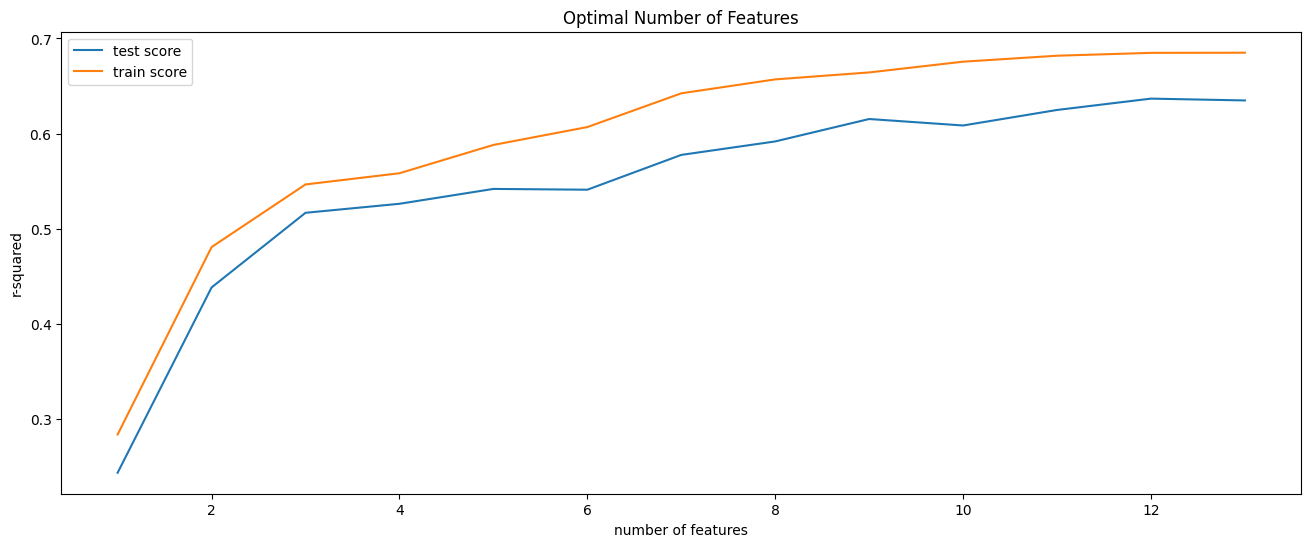

In [36]:
# plotting cv results
plt.figure(figsize=(16, 6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("r-squared")
plt.title("Optimal Number of Features")
plt.legend(["test score", "train score"], loc="upper left")

In [37]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5995575338728532


# Example 2: Car Price Prediction

In [38]:
# reading the dataset
cars = pd.read_csv("../../../Data/CarPrice.csv")
cars.shape

(205, 26)

In [39]:
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [40]:
cars.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [41]:
# All data preparation steps in this cell

# converting symboling to categorical
cars["symboling"] = cars["symboling"].astype("object")


# create new column: car_company
p = re.compile(r"\w+-?\w+")
cars["car_company"] = cars["CarName"].apply(lambda x: re.findall(p, x)[0])


# replacing misspelled car_company names
# volkswagen
cars.loc[
    (cars["car_company"] == "vw") | (cars["car_company"] == "vokswagen"), "car_company"
] = "volkswagen"
# porsche
cars.loc[cars["car_company"] == "porcshce", "car_company"] = "porsche"
# toyota
cars.loc[cars["car_company"] == "toyouta", "car_company"] = "toyota"
# nissan
cars.loc[cars["car_company"] == "Nissan", "car_company"] = "nissan"
# mazda
cars.loc[cars["car_company"] == "maxda", "car_company"] = "mazda"


# drop carname variable
cars = cars.drop("CarName", axis=1)


# split into X and y
X = cars.loc[
    :,
    [
        "symboling",
        "fueltype",
        "aspiration",
        "doornumber",
        "carbody",
        "drivewheel",
        "enginelocation",
        "wheelbase",
        "carlength",
        "carwidth",
        "carheight",
        "curbweight",
        "enginetype",
        "cylindernumber",
        "enginesize",
        "fuelsystem",
        "boreratio",
        "stroke",
        "compressionratio",
        "horsepower",
        "peakrpm",
        "citympg",
        "highwaympg",
        "car_company",
    ],
]
y = cars["price"]


# creating dummy variables for categorical variables
cars_categorical = X.select_dtypes(include=["object"])
cars_categorical.head()


# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()


# drop categorical variables
X = X.drop(list(cars_categorical.columns), axis=1)


# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)


# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=40
)

In [42]:
# number of features
len(X_train.columns)

68

In [43]:
# creating a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=100)

# specify range of hyperparameters
hyper_params = [{"n_features_to_select": list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# set up GridSearchCV()
model_cv = GridSearchCV(
    estimator=rfe,
    param_grid=hyper_params,
    scoring="r2",
    cv=folds,
    verbose=1,
    return_train_score=True,
)

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [44]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.062653,0.004325,0.003931,0.005951,2,{'n_features_to_select': 2},0.712322,0.673284,0.839691,0.643727,...,0.716972,0.066867,35,0.693638,0.809346,0.768171,0.798515,0.798908,0.773715,0.042337
1,0.062572,0.000176,0.000000,0.000000,3,{'n_features_to_select': 3},0.817568,0.720574,0.864579,0.675851,...,0.704190,0.147102,38,0.796890,0.868796,0.833999,0.850420,0.845840,0.839189,0.023930
2,0.066995,0.003585,0.000000,0.000000,4,{'n_features_to_select': 4},0.829413,0.812420,0.862303,0.735701,...,0.736991,0.151742,33,0.834392,0.904158,0.894407,0.881821,0.850000,0.872956,0.026557
3,0.057564,0.009369,0.003298,0.006596,5,{'n_features_to_select': 5},0.669211,0.814914,0.864962,0.768708,...,0.710741,0.151825,37,0.863963,0.907896,0.897645,0.911010,0.895627,0.895228,0.016692
4,0.064709,0.003235,0.000293,0.000397,6,{'n_features_to_select': 6},0.675174,0.811662,0.873897,0.764830,...,0.713445,0.150574,36,0.864405,0.908017,0.901539,0.912918,0.909751,0.899326,0.017851
5,0.062756,0.006259,0.000200,0.000399,7,{'n_features_to_select': 7},0.619241,0.815732,0.854447,0.765352,...,0.720774,0.117179,34,0.875107,0.908596,0.909011,0.914559,0.926074,0.906669,0.016995
6,0.062825,0.000908,0.000000,0.000000,8,{'n_features_to_select': 8},0.608348,0.861613,0.848157,0.763983,...,0.775633,0.090763,29,0.887177,0.926444,0.924470,0.914797,0.930265,0.916631,0.015585
7,0.059418,0.006486,0.000000,0.000000,9,{'n_features_to_select': 9},0.638207,0.868169,0.848157,0.763969,...,0.780507,0.080989,26,0.889975,0.929960,0.924470,0.914826,0.934186,0.918683,0.015748
8,0.056144,0.005315,0.000000,0.000000,10,{'n_features_to_select': 10},0.637811,0.871081,0.854378,0.763966,...,0.786477,0.083337,20,0.889975,0.932598,0.931169,0.914828,0.939454,0.921605,0.017761
9,0.063271,0.000975,0.000000,0.000000,11,{'n_features_to_select': 11},0.637811,0.849864,0.860012,0.684470,...,0.769020,0.090674,31,0.889975,0.935176,0.936501,0.924168,0.940519,0.925268,0.018459


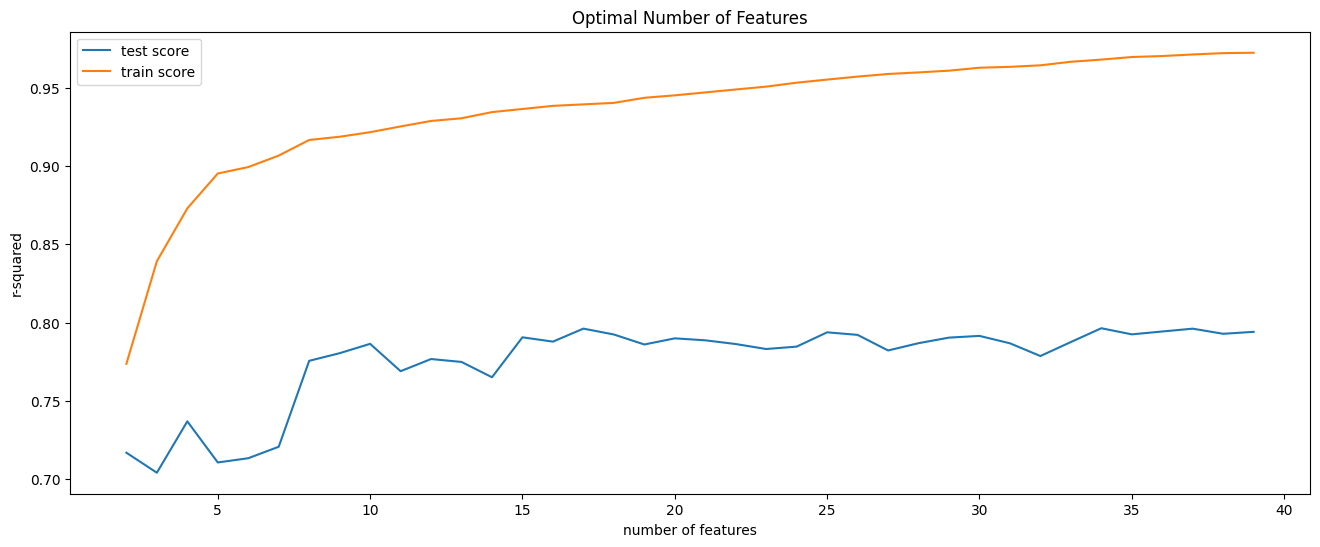

In [45]:
# plotting cv results
plt.figure(figsize=(16, 6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("r-squared")
plt.title("Optimal Number of Features")
plt.legend(["test score", "train score"], loc="upper left")